In [1]:
import os
import numpy as np
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F

In [2]:
def generate_toy_data(mean, cov=[[1,0.8],[0.8,1]], num_samples=500):
    z = np.random.multivariate_normal(mean=mean,
                                      cov=cov,
                                      size=num_samples)
    return z

[0.83302042]


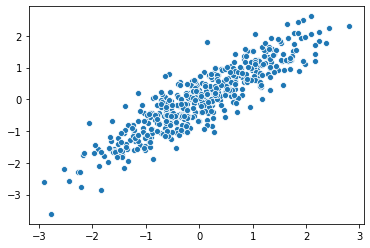

In [3]:
data = generate_toy_data([0,0], [[1, .9], [.9, 1]])
print(mutual_info_regression(data[:,:1], data[:,1]))
sns.scatterplot(data[:,0], data[:,1])

In [22]:
class MINE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc3 = nn.Linear(hidden_dim, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
def compute_mi_sup(pxz, pz):
    return torch.mean(pxz) - torch.log(torch.mean(torch.exp(pz)))


def neural_info_measure(net, xz, z):
    """Computes the neural information measure described in eqn. 10 of 
    https://arxiv.org/pdf/1801.04062.pdf
    
    Lemma 1 of the paper states that neural information measure approximates 
    the mutual information to an arbituarily small epsilon for some deeeeeep 
    neural network.
    
    Parameters
    ----------
    net : nn.Module
        MINE statistics network.
    xz : torch.Tensor
        Samples from the joint distribution XZ.
    z : torch.Tensor
        Samples from the marginal distribution Z.
        
    """
    pxz = net(xz)
    pz = net(z)
    mi_sup = torch.mean(pxz) - torch.log(torch.mean(torch.exp(pz)))
    return mi_sup, pxz, pz


def algorithm_1(net, X, batch_size=64, ):
    """Performs algorithm 1 of MINE.
    
        (i)   Draw b minibatch samples from the joint distribution P_XZ: 
                  (x_1, z_1), ..., (x_b, z_b)
        (ii)  Draw n samples from the marginal distribution P_Z: 
                  ~z_1, ..., ~z_b
        (iii) Evaluate the lower-bound: 
                  V(θ) = 1/b * sum_b ( T(x_i, z_i) ) - log ( 1/b * sum_b ( exp( T(x_i, ~z_i) ) )
        (iv)  Evaluate bias corrected gradients: 
                  G(θ) ← grad(V(θ))
        (v)   Update the statistics network parameters: 
                  θ += G(θ) 

    """
    xz, z = sample_batch(X, batch_size)
    mi_sup, pxz, pz = neural_info_measure(net, xz, z)
    
    
class Sampler:
    
    def __init__(self, data_source, batch_size=64):
        self.data_source = data_source
        self.batch_size = batch_size
    
    @property
    def data(self):
        return self.data_source
    
    def __len__(self):
        return len(self.data_source)
    
    def _sample(self, idx):
        xz = self.data_source[idx * self.batch_size : (idx+1) * self.batch_size]
        z = xz.clone()
        bs = len(xz)
        idx = np.random.choice(range(bs), bs, replace=True)
        z[:,1] = z[idx, 1]
        return xz, z
        
    def __getitem__(self, idx):
        return self._sample(idx)
        

In [8]:
def ewa(x, x_prev, beta=.1):
    return beta * x + (1 - beta) * x_prev if x_prev else x

def moving_average(x, x_prev, beta=.1):
    return beta * x + (1 - beta) * x_prev if x_prev else x   
        
def generate_predictions(net, sampler):
    pxz = torch.Tensor([])
    pz = torch.Tensor([])
    for idx in range(len(sampler)):
        xz_batch, z_batch = sampler[idx]
        pxz = torch.cat([pxz, net(xz_batch)])
        pz = torch.cat([pz, net(z_batch)])
    
    return pxz, pz

[0.812003]


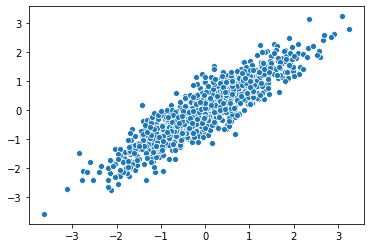

In [15]:
var = .9
num_samples = 1000
data = generate_toy_data([0,0], [[1, var], [var, 1]], num_samples=num_samples)
target_mi = mutual_info_regression(data[:,:1], data[:,1],)
print(target_mi)
sns.scatterplot(data[:,0], data[:,1])

In [20]:
sampler = Sampler(torch.autograd.Variable(torch.FloatTensor(data)))

epochs = 50
batch_size = 64
num_batches = int(np.ceil(len(sampler) / batch_size)) - 1

net = MINE(2, 100)
optim = torch.optim.Adam(net.parameters(), 1e-3)

In [21]:
losses = []
batch_mis = []
mi_scores = []

for epoch in range(epochs):
    batch_mi = 0
    y_preds = []
    batch_indices = np.random.choice(range(num_batches), num_batches, replace=False)
    for i, idx in enumerate(batch_indices):
        xz_batch, z_batch = sampler[idx]
        mi_sup, pxz, pz = neural_info_measure(net, xz_batch, z_batch)
        loss = -mi_sup
        batch_mi = ewa(mi_sup, batch_mi)
        batch_mis.append(batch_mi)
        
        net.zero_grad()
        loss.backward()
        optim.step()
    
    pxz, pz = generate_predictions(net, sampler)
    mi_sup = compute_mi_sup(pxz, pz)
    mi_scores.append(mi_sup)
    
    print(f'step {epoch} - MI_batch : {batch_mi:.5f} - MI : {mi_sup:.5f}')

step 0 - MI_batch : 0.20812 - MI : 0.41319
step 1 - MI_batch : 0.53146 - MI : 0.61758
step 2 - MI_batch : 0.58320 - MI : 0.66712
step 3 - MI_batch : 0.80541 - MI : 0.76510
step 4 - MI_batch : 0.76400 - MI : 0.82029
step 5 - MI_batch : 0.67438 - MI : 0.76722
step 6 - MI_batch : 0.87542 - MI : 0.74311
step 7 - MI_batch : 0.85410 - MI : 0.81122
step 8 - MI_batch : 0.76098 - MI : 0.76355
step 9 - MI_batch : 0.79605 - MI : 0.77445
step 10 - MI_batch : 0.83595 - MI : 0.76628
step 11 - MI_batch : 0.74660 - MI : 0.72841
step 12 - MI_batch : 0.89180 - MI : 0.79197
step 13 - MI_batch : 0.78143 - MI : 0.81475
step 14 - MI_batch : 0.67076 - MI : 0.72228
step 15 - MI_batch : 0.78982 - MI : 0.78686
step 16 - MI_batch : 0.74685 - MI : 0.80059
step 17 - MI_batch : 0.79825 - MI : 0.70535
step 18 - MI_batch : 0.76781 - MI : 0.69828
step 19 - MI_batch : 0.77169 - MI : 0.84926
step 20 - MI_batch : 0.82374 - MI : 0.84224
step 21 - MI_batch : 0.80518 - MI : 0.75410
step 22 - MI_batch : 0.81290 - MI : 0.7064

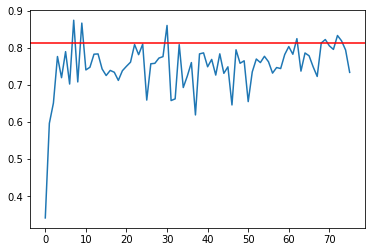

In [19]:
plt.plot(mi_scores, label='MINE')
plt.axhline(target_mi, color='red', label='target MI')